In [4]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

### Prepare for infused features

In [2]:
# read the oneformer csv file
oneformer = pd.read_csv('../../0_data/1_intermediate_OneFormer/segmentation_preds_all.csv')
# normalize the data so that it's between 0 and 1
for col in oneformer.columns:
    if '_count' in col:
        oneformer[col] = oneformer[col] / oneformer[col].max()
oneformer.head()

,image_id,road,sidewalk,pole,traffic sign,vegetation,terrain,sky,car,traffic light,...,bus_count,bicycle_count,rider_count,motorcycle_count,lead_car_car_count,lead_car_person_count,lead_car_bus_count,lead_car_bicycle_count,lead_car_rider_count,lead_car_motorcycle_count
0,001_0,0.220,0.000,0.008,0.000,0.349,0.146,0.254,0.018,0.0,...,0.0,0.0,0.0,0.0,0.285714,0.0,0.0,0.0,0.0,0.0
1,001_114,0.214,0.016,0.004,0.009,0.237,0.117,0.392,0.011,0.0,...,0.0,0.0,0.0,0.0,0.190476,0.0,0.0,0.0,0.0,0.0
2,001_152,0.215,0.028,0.009,0.000,0.250,0.090,0.394,0.013,0.0,...,0.0,0.0,0.0,0.0,0.285714,0.0,0.0,0.0,0.0,0.0
3,001_189,0.247,0.000,0.008,0.000,0.365,0.033,0.331,0.016,0.0,...,0.0,0.0,0.0,0.0,0.380952,0.0,0.0,0.0,0.0,0.0
4,001_225,0.227,0.049,0.004,0.000,0.219,0.000,0.360,0.034,0.0,...,0.0,0.0,0.0,0.0,0.238095,0.0,0.0,0.0,0.0,0.0


In [3]:
# read the semantic features
semantic = pd.read_csv('../../0_data/1_intermediate_LLM/semantic_results_all_images_finalized.csv')
# one-hot encode the categorical features
semantic = pd.get_dummies(
    semantic, 
    columns=['weather', 'traffic_condition', 'road_condition', 'visibility', 'time_of_day', 'road_layout', 'road_type', 'road_width'],
    drop_first=True)
# change TRUE FALSE to 1 0
features = ['weather_cloudy', 'weather_foggy',
       'weather_rainy', 'weather_snowy', 'traffic_condition_light',
       'traffic_condition_moderate', 'road_condition_icy',
       'road_condition_wet', 'visibility_low visibility',
       'time_of_day_dusk/dawn', 'time_of_day_night',
       'road_layout_slight curve', 'road_layout_straight', 'road_type_highway',
       'road_type_parking', 'road_type_residential area',
       'road_type_rural road', 'road_width_narrow', 'road_width_wide']
for feature in features:
    semantic[feature] = semantic[feature].astype(int)
semantic.head()

,demanding_level,image_id,weather_cloudy,weather_foggy,weather_rainy,weather_snowy,traffic_condition_light,traffic_condition_moderate,road_condition_icy,road_condition_wet,...,time_of_day_dusk/dawn,time_of_day_night,road_layout_slight curve,road_layout_straight,road_type_highway,road_type_parking,road_type_residential area,road_type_rural road,road_width_narrow,road_width_wide
0,5.0,001_0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4.0,001_37,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3.0,001_75,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.0,001_114,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.0,001_152,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
driving = pd.read_csv('../../0_data/1_intermediate_driving/all_avt_data_gps_crash_likelihood_speed.csv')
del driving['lat']
del driving['lon']
del driving['crash_likelihood']
del driving['speed_limit']
driving.head()

,epoch_index,frame,speed,speed_std,speed_mean,lon_acceleration_mean,lon_acceleration_std,lon_acceleration_max,lon_acceleration_min,speed_deviation,speed_deviation_normalized
0,1,0,36.80,0.239705,36.374324,-0.301752,0.937620,0.804672,-4.693920,-18.20,-0.330909
1,1,37,35.99,0.229641,35.630000,-0.254107,0.536257,0.134112,-2.011680,-19.01,-0.345636
2,1,75,35.27,0.097545,35.104615,0.000000,0.858184,3.486912,-2.011680,-19.73,-0.358727
3,1,114,35.47,0.190696,35.866053,0.296458,1.015236,3.218688,-2.279904,-19.53,-0.355091
4,1,152,36.11,0.264141,36.432703,0.264599,0.634172,2.414016,-0.804672,-18.89,-0.343455


In [5]:
# normalize the features in driving so that it has a mean of 0 and a standard deviation of 1
for col in driving.columns:
    if col != 'epoch_index' and col != 'frame':
        driving[col] = (driving[col] - driving[col].mean()) / driving[col].std()

In [6]:
# convert to int
driving['epoch_index'] = driving['epoch_index'].astype(int)
driving['frame'] = driving['frame'].astype(int)

In [7]:
all_data = pd.merge(oneformer, semantic, on='image_id')
all_data['epoch_index'] = all_data['image_id'].apply(lambda x: int(x.split('_')[0]))
all_data['frame'] = all_data['image_id'].apply(lambda x: int(x.split('_')[1]))
# all_data = pd.merge(all_data, driving, on=['epoch_index', 'frame'], how='right')
all_data.head()

,image_id,road,sidewalk,pole,traffic sign,vegetation,terrain,sky,car,traffic light,...,road_layout_slight curve,road_layout_straight,road_type_highway,road_type_parking,road_type_residential area,road_type_rural road,road_width_narrow,road_width_wide,epoch_index,frame
0,001_0,0.220,0.000,0.008,0.000,0.349,0.146,0.254,0.018,0.0,...,0,0,0,0,0,0,0,0,1,0
1,001_114,0.214,0.016,0.004,0.009,0.237,0.117,0.392,0.011,0.0,...,0,0,0,0,0,0,0,0,1,114
2,001_152,0.215,0.028,0.009,0.000,0.250,0.090,0.394,0.013,0.0,...,0,0,0,0,0,0,0,0,1,152
3,001_189,0.247,0.000,0.008,0.000,0.365,0.033,0.331,0.016,0.0,...,0,0,0,0,0,0,0,0,1,189
4,001_225,0.227,0.049,0.004,0.000,0.219,0.000,0.360,0.034,0.0,...,0,0,0,0,0,0,0,0,1,225


In [40]:
all_data = pd.merge(all_data, driving, on=['epoch_index', 'frame'], how='inner')
all_data.to_csv('../../0_data/1_intermediate_ML/all_features_one_hot_data.csv', index=False)

In [2]:
all_data = pd.read_csv('../../0_data/1_intermediate_ML/all_features_one_hot_data.csv')
mturk_data = pd.read_csv('../../0_data/1_intermediate_annotation/MTurk_results.csv')
# join the two dataframes on image_id
all_data = pd.merge(all_data, mturk_data, on='image_id', how='inner')

In [3]:
all_data.to_csv('../../0_data/1_intermediate_ML/all_features_one_hot_data_mturk.csv', index=False)

### Oneformer features

In [5]:
# read the oneformer csv file
oneformer = pd.read_csv('../../0_data/1_intermediate_OneFormer/segmentation_preds_all.csv')
print(oneformer.columns)
oneformer.head()

Index(['image_id', 'road', 'sidewalk', 'pole', 'traffic sign', 'vegetation',
       'terrain', 'sky', 'car', 'traffic light', 'building', 'wall', 'fence',
       'truck', 'bicycle', 'person', 'train', 'bus', 'rider', 'motorcycle',
       'lead_car_road', 'lead_car_sidewalk', 'lead_car_pole',
       'lead_car_traffic sign', 'lead_car_vegetation', 'lead_car_terrain',
       'lead_car_sky', 'lead_car_car', 'lead_car_traffic light',
       'lead_car_building', 'lead_car_wall', 'lead_car_fence',
       'lead_car_truck', 'lead_car_bicycle', 'lead_car_person',
       'lead_car_train', 'lead_car_bus', 'lead_car_rider',
       'lead_car_motorcycle', 'car_count', 'person_count', 'bus_count',
       'bicycle_count', 'rider_count', 'motorcycle_count',
       'lead_car_car_count', 'lead_car_person_count', 'lead_car_bus_count',
       'lead_car_bicycle_count', 'lead_car_rider_count',
       'lead_car_motorcycle_count'],
      dtype='object')


,image_id,road,sidewalk,pole,traffic sign,vegetation,terrain,sky,car,traffic light,...,bus_count,bicycle_count,rider_count,motorcycle_count,lead_car_car_count,lead_car_person_count,lead_car_bus_count,lead_car_bicycle_count,lead_car_rider_count,lead_car_motorcycle_count
0,001_0,0.220,0.000,0.008,0.000,0.349,0.146,0.254,0.018,0.0,...,0,0,0,0,6,0,0,0,0,0
1,001_114,0.214,0.016,0.004,0.009,0.237,0.117,0.392,0.011,0.0,...,0,0,0,0,4,0,0,0,0,0
2,001_152,0.215,0.028,0.009,0.000,0.250,0.090,0.394,0.013,0.0,...,0,0,0,0,6,0,0,0,0,0
3,001_189,0.247,0.000,0.008,0.000,0.365,0.033,0.331,0.016,0.0,...,0,0,0,0,8,0,0,0,0,0
4,001_225,0.227,0.049,0.004,0.000,0.219,0.000,0.360,0.034,0.0,...,0,0,0,0,5,0,0,0,0,0


In [6]:
key_oneformer_features = [
    'road', 'vegetation', 'sky', 'terrain', 'car', 'sidewalk', 'building', 'traffic light', 'person',
    'lead_car_traffic sign', 'lead_car_road', 'lead_car_vegetation', 'lead_car_sky', 'lead_car_car',
    'lead_car_fence', 'car_count', 'lead_car_car_count', 'image_id'
]
oneformer = oneformer[key_oneformer_features]

In [7]:
# oneformer['vegetation'] = np.log(oneformer['vegetation'] + 0.001)
oneformer['terrain'] = np.log(oneformer['terrain'] + 0.001)
oneformer['car'] = np.log(oneformer['car'] + 0.001)
oneformer['sidewalk'] = np.log(oneformer['sidewalk'] + 0.001)
oneformer['building'] = np.log(oneformer['building'] + 0.001)
oneformer['traffic light'] = np.log(oneformer['traffic light'] + 0.001)
oneformer['person'] = np.log(oneformer['person'] + 0.001)
oneformer['lead_car_traffic sign'] = np.log(oneformer['lead_car_traffic sign'] + 0.001)
oneformer['lead_car_road'] = np.log(oneformer['lead_car_road'] + 0.001)
oneformer['lead_car_vegetation'] = np.log(oneformer['lead_car_vegetation'] + 0.001)
# correct the left skewed features
oneformer['lead_car_sky'] = np.exp(oneformer['lead_car_sky'])

oneformer['lead_car_car'] = np.log(oneformer['lead_car_car'] + 0.001)
oneformer['lead_car_fence'] = np.log(oneformer['lead_car_fence'] + 0.001)
# oneformer['car_count'] = np.log(oneformer['car_count'] + 0.001)

In [8]:
# delete features that are not useful
oneformer = oneformer.drop(columns=['terrain', 'traffic light', 'person', 'lead_car_traffic sign', 'lead_car_fence'])

In [9]:
# normalize the count variables
oneformer['car_count'] = oneformer['car_count'] / oneformer['car_count'].max()
oneformer['lead_car_car_count'] = oneformer['lead_car_car_count'] / oneformer['lead_car_car_count'].max()

### Contextual features

In [10]:
# read the semantic features
semantic = pd.read_csv('../../0_data/1_intermediate_LLM/semantic_results_all_images_finalized.csv')
print(semantic.columns)
semantic.head()

Index(['demanding_level', 'weather', 'road_condition', 'traffic_condition',
       'visibility', 'time_of_day', 'road_layout', 'road_type', 'road_width',
       'image_id'],
      dtype='object')


,demanding_level,weather,road_condition,traffic_condition,visibility,time_of_day,road_layout,road_type,road_width,image_id
0,5.0,cloudy,dry,moderate,clear,day,curved,city street,medium,001_0
1,4.0,cloudy,dry,moderate,clear,day,curved,city street,medium,001_37
2,3.0,cloudy,dry,moderate,clear,day,curved,city street,medium,001_75
3,3.0,cloudy,dry,moderate,clear,day,curved,city street,medium,001_114
4,4.0,cloudy,dry,moderate,clear,day,curved,city street,medium,001_152


In [11]:
# one-hot encode the categorical features
semantic = pd.get_dummies(
    semantic, 
    columns=['weather', 'traffic_condition', 'road_condition', 'visibility', 'time_of_day', 'road_layout', 'road_type', 'road_width'],
    drop_first=True)
semantic.columns

Index(['demanding_level', 'image_id', 'weather_cloudy', 'weather_foggy',
       'weather_rainy', 'weather_snowy', 'traffic_condition_light',
       'traffic_condition_moderate', 'road_condition_icy',
       'road_condition_wet', 'visibility_low visibility',
       'time_of_day_dusk/dawn', 'time_of_day_night',
       'road_layout_slight curve', 'road_layout_straight', 'road_type_highway',
       'road_type_parking', 'road_type_residential area',
       'road_type_rural road', 'road_width_narrow', 'road_width_wide'],
      dtype='object')

In [12]:
# change TRUE FALSE to 1 0
features = ['weather_cloudy', 'weather_foggy',
       'weather_rainy', 'weather_snowy', 'traffic_condition_light',
       'traffic_condition_moderate', 'road_condition_icy',
       'road_condition_wet', 'visibility_low visibility',
       'time_of_day_dusk/dawn', 'time_of_day_night',
       'road_layout_slight curve', 'road_layout_straight', 'road_type_highway',
       'road_type_parking', 'road_type_residential area',
       'road_type_rural road', 'road_width_narrow', 'road_width_wide']
for feature in features:
    semantic[feature] = semantic[feature].astype(int)

In [13]:
del semantic['demanding_level']

### Driving features

In [14]:
driving = pd.read_csv('../../0_data/1_intermediate_driving/all_avt_data_gps_crash_likelihood_speed.csv')
del driving['lat']
del driving['lon']
del driving['speed_limit']
driving.head()

,epoch_index,frame,speed,speed_std,speed_mean,lon_acceleration_mean,lon_acceleration_std,lon_acceleration_max,lon_acceleration_min,crash_likelihood,speed_deviation,speed_deviation_normalized
0,1,0,36.80,0.239705,36.374324,-0.301752,0.937620,0.804672,-4.693920,301.985535,-18.20,-0.330909
1,1,37,35.99,0.229641,35.630000,-0.254107,0.536257,0.134112,-2.011680,317.670074,-19.01,-0.345636
2,1,75,35.27,0.097545,35.104615,0.000000,0.858184,3.486912,-2.011680,317.670074,-19.73,-0.358727
3,1,114,35.47,0.190696,35.866053,0.296458,1.015236,3.218688,-2.279904,317.670074,-19.53,-0.355091
4,1,152,36.11,0.264141,36.432703,0.264599,0.634172,2.414016,-0.804672,331.677277,-18.89,-0.343455


### Complexity-infused features

In [37]:
complexity = pd.read_csv('../../0_data/1_intermediate_ML/complexity_infused_data_32_continuous_demanding_all_mturk.csv')
print(complexity.columns)

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', 'image_id',
       'demanding_level'],
      dtype='object')


### Crash data

In [13]:
# crash_data = pd.read_csv('../../0_data/1_intermediate_crash/all_avt_data_gps_crash_likelihood.csv')
# crash_data.head()

(array([3612., 1070.,  776., 1019.,  716.,  735.,  636.,  448.,  378.,
         225.,  131.,  146.,   83.,   61.,   92.,   63.,   18.,   16.,
           8.,   40.]),
 array([4.45995862e-06, 4.93804770e-01, 9.87605080e-01, 1.48140539e+00,
        1.97520570e+00, 2.46900601e+00, 2.96280632e+00, 3.45660663e+00,
        3.95040694e+00, 4.44420725e+00, 4.93800756e+00, 5.43180787e+00,
        5.92560818e+00, 6.41940849e+00, 6.91320880e+00, 7.40700911e+00,
        7.90080942e+00, 8.39460973e+00, 8.88841004e+00, 9.38221035e+00,
        9.87601066e+00]),
 <BarContainer object of 20 artists>)

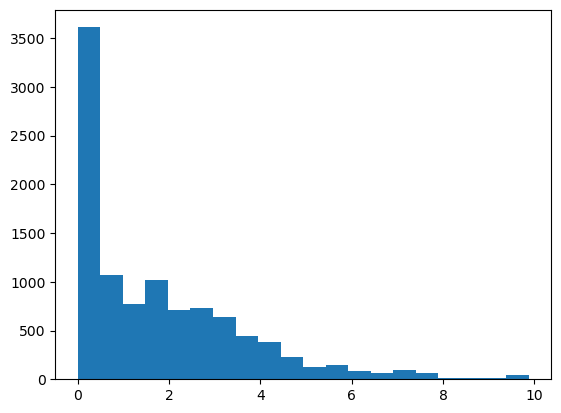

In [16]:
# delete the rows whose likelihood is less than -100
driving = driving[driving['crash_likelihood'] > -100]
# divide the likelihood by the maximum likelihood
driving['crash_likelihood'] = driving['crash_likelihood'] * 10 / (driving['crash_likelihood'].max() + 10)
plt.hist(driving['crash_likelihood'], bins=20)

### Joining datasets

In [38]:
# join oneformer and semantic
data = pd.merge(oneformer, semantic, how='inner', on='image_id')
# join complexity
data = pd.merge(data, complexity, how='inner', on='image_id')

In [39]:
len(list(set(semantic['image_id']) - set(complexity['image_id'])))

1789

In [40]:
# split the image id column by _
data['epoch_index'] = data['image_id'].str.split('_').str[0].astype(int)
data['frame'] = data['image_id'].str.split('_').str[1].astype(int)

In [41]:
data = pd.merge(data, driving, how='inner', on=['epoch_index', 'frame'])

In [42]:
del data['epoch_index']
del data['frame']

In [43]:
data['demanding_level'].head()

0    4.300000
1    3.000000
2    4.333333
3    3.666667
4    3.333333
Name: demanding_level, dtype: float64

In [44]:
data.columns

Index(['road', 'vegetation', 'sky', 'car', 'sidewalk', 'building',
       'lead_car_road', 'lead_car_vegetation', 'lead_car_sky', 'lead_car_car',
       'car_count', 'lead_car_car_count', 'image_id', 'weather_cloudy',
       'weather_foggy', 'weather_rainy', 'weather_snowy',
       'traffic_condition_light', 'traffic_condition_moderate',
       'road_condition_icy', 'road_condition_wet', 'visibility_low visibility',
       'time_of_day_dusk/dawn', 'time_of_day_night',
       'road_layout_slight curve', 'road_layout_straight', 'road_type_highway',
       'road_type_parking', 'road_type_residential area',
       'road_type_rural road', 'road_width_narrow', 'road_width_wide', '0',
       '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '26', '27', '28', '29', '30', '31', 'demanding_level', 'speed',
       'speed_std', 'speed_mean', 'lon_acceleration_mean',
       'lon_acceleration_std

In [45]:
# normalize the features in driving so that it has a mean of 0 and a standard deviation of 1
for col in ['speed', 'speed_std', 'speed_mean',
       'lon_acceleration_mean', 'lon_acceleration_std', 'lon_acceleration_max',
       'lon_acceleration_min', 'speed_deviation',
       'speed_deviation_normalized']:
    data[col] = (data[col] - data[col].mean()) / data[col].std()

In [46]:
data.to_csv('../../0_data/1_intermediate_ML/selected_features_one_hot_complexity_32_continuous_demanding_all_crash_mturk.csv', index=False)

# Archive

In [4]:
# read the labels
# TODO no need to read the labels here
labels = pd.read_csv('../../0_data/1_intermediate_annotation/merged_annotations_final.csv')
print(labels.columns)
labels.head()

Index(['image_id', 'Low', 'Medium', 'High', 'agreement', 'final_label'], dtype='object')


,image_id,Low,Medium,High,agreement,final_label
0,001_0,2,1,0,0.666667,Low
1,002_0,2,1,0,0.666667,Low
2,003_0,0,3,0,1.000000,Medium
3,004_0,2,1,0,0.666667,Low
4,005_0,3,0,0,1.000000,Low


In [12]:
# merge the dataframes
data = pd.merge(oneformer, semantic, on='image_id', how='inner')
# data = pd.merge(data, labels[['image_id', 'final_label']], on='image_id', how='inner')

### One-hot encoding on the big dataset

In [5]:
data.columns

Index(['image_id', 'road', 'pole', 'traffic sign', 'vegetation', 'terrain',
       'sky', 'car', 'sidewalk', 'building', 'fence', 'truck', 'wall',
       'traffic light', 'person', 'bus', 'bicycle', 'rider', 'motorcycle',
       'train', 'lead_car_road', 'lead_car_pole', 'lead_car_traffic sign',
       'lead_car_vegetation', 'lead_car_terrain', 'lead_car_sky',
       'lead_car_car', 'lead_car_sidewalk', 'lead_car_building',
       'lead_car_fence', 'lead_car_truck', 'lead_car_wall',
       'lead_car_traffic light', 'lead_car_person', 'lead_car_bus',
       'lead_car_bicycle', 'lead_car_rider', 'lead_car_motorcycle',
       'lead_car_train', 'car_count', 'person_count', 'bus_count',
       'bicycle_count', 'rider_count', 'motorcycle_count',
       'lead_car_car_count', 'lead_car_person_count', 'lead_car_bus_count',
       'lead_car_bicycle_count', 'lead_car_rider_count',
       'lead_car_motorcycle_count', 'demanding_level', 'weather',
       'road_condition', 'traffic_condition', 'visi

In [6]:
print(data['weather'].value_counts())
print(data['traffic_condition'].value_counts())
print(data['road_condition'].value_counts())
print(data['visibility'].value_counts())
print(data['time_of_day'].value_counts())
print(data['road_layout'].value_counts())
print(data['road_type'].value_counts())
print(data['road_width'].value_counts())

weather
clear     541
cloudy    404
rainy      26
snowy      21
foggy       7
Name: count, dtype: int64
traffic_condition
moderate    692
light       276
heavy        31
Name: count, dtype: int64
road_condition
dry    836
wet    137
icy     26
Name: count, dtype: int64
visibility
clear             913
low visibility     86
Name: count, dtype: int64
time_of_day
day          802
dusk/dawn    150
night         47
Name: count, dtype: int64
road_layout
straight        709
curved          145
slight curve    144
unknown           1
Name: count, dtype: int64
road_type
highway             657
city street         180
rural road           90
residential area     67
parking               4
unknown               1
Name: count, dtype: int64
road_width
wide       521
medium     455
narrow      22
unknown      1
Name: count, dtype: int64


In [13]:
# one-hot encode the categorical features
data = pd.get_dummies(
    data, 
    columns=['weather', 'traffic_condition', 'road_condition', 'visibility', 'time_of_day', 'road_layout', 'road_type', 'road_width'],
    drop_first=True)
data.columns

Index(['image_id', 'road', 'pole', 'traffic sign', 'vegetation', 'terrain',
       'sky', 'car', 'sidewalk', 'building', 'fence', 'truck', 'wall',
       'traffic light', 'person', 'bus', 'bicycle', 'rider', 'motorcycle',
       'train', 'lead_car_road', 'lead_car_pole', 'lead_car_traffic sign',
       'lead_car_vegetation', 'lead_car_terrain', 'lead_car_sky',
       'lead_car_car', 'lead_car_sidewalk', 'lead_car_building',
       'lead_car_fence', 'lead_car_truck', 'lead_car_wall',
       'lead_car_traffic light', 'lead_car_person', 'lead_car_bus',
       'lead_car_bicycle', 'lead_car_rider', 'lead_car_motorcycle',
       'lead_car_train', 'car_count', 'person_count', 'bus_count',
       'bicycle_count', 'rider_count', 'motorcycle_count',
       'lead_car_car_count', 'lead_car_person_count', 'lead_car_bus_count',
       'lead_car_bicycle_count', 'lead_car_rider_count',
       'lead_car_motorcycle_count', 'demanding_level', 'weather_cloudy',
       'weather_foggy', 'weather_rainy', 'we

In [14]:
# change TRUE FALSE to 1 0
features = ['weather_cloudy',
       'weather_foggy', 'weather_rainy', 'weather_snowy',
       'traffic_condition_light', 'traffic_condition_moderate',
       'road_condition_icy', 'road_condition_wet', 'visibility_low visibility',
       'time_of_day_dusk/dawn', 'time_of_day_night',
       'road_layout_slight curve', 'road_layout_straight',
       'road_layout_unknown', 'road_type_highway', 'road_type_parking',
       'road_type_residential area', 'road_type_rural road',
       'road_type_unknown', 'road_width_narrow', 'road_width_unknown',
       'road_width_wide']
for feature in features:
    data[feature] = data[feature].astype(int)

In [15]:
data.to_csv('../../0_data/1_intermediate_ML/all_features_one_hot_data.csv', index=False)

### Feature engineering

final_label
Medium    253
Low       165
High       82
Name: count, dtype: int64
4.2303030303030305
5.067193675889328
6.073170731707317


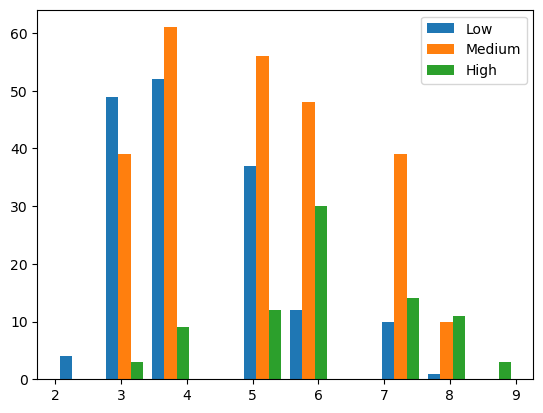

In [26]:
# plot categorical histogram of demanding_level separated by final_label
data['demanding_level'] = data['demanding_level'].astype('int')
data['final_label'] = data['final_label'].astype('category')

print(data['final_label'].value_counts())
print(data[data['final_label'] == 'Low']['demanding_level'].mean())
print(data[data['final_label'] == 'Medium']['demanding_level'].mean())
print(data[data['final_label'] == 'High']['demanding_level'].mean())
plt.hist([data[data['final_label'] == 'Low']['demanding_level'], 
          data[data['final_label'] == 'Medium']['demanding_level'], 
          data[data['final_label'] == 'High']['demanding_level']], stacked=False, label=['Low', 'Medium', 'High'])
plt.legend()

In [19]:
key_oneformer_features = [
    'road', 'vegetation', 'sky', 'terrain', 'car', 'sidewalk', 'building', 'traffic light', 'person',
    'lead_car_traffic sign', 'lead_car_road', 'lead_car_vegetation', 'lead_car_sky', 'lead_car_car',
    'lead_car_fence', 'car_count', 'lead_car_car_count'
]
key_semantic_features = [
    'weather', 'traffic_condition', 'time_of_day', 'road_type', 'road_width', 'demanding_level'
]

In [20]:
sub_data = data[key_oneformer_features + key_semantic_features + ['final_label']]
sub_data.to_csv('../../0_data/1_intermediate_ML/selected_data.csv', index=False)

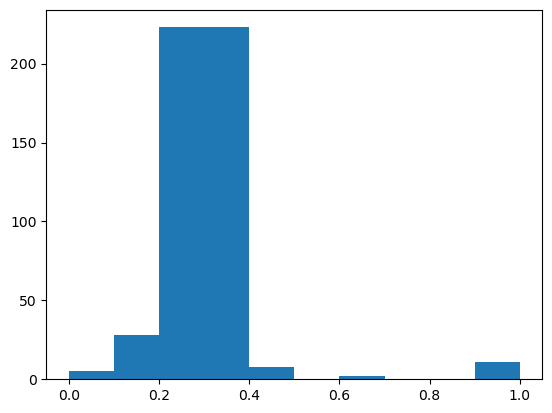

In [24]:
# correct the right skewed features
sub_data = pd.read_csv('../../0_data/1_intermediate_ML/selected_features_data.csv')
plt.hist(sub_data['road'])
plt.show()
# sub_data['road'] = np.log(sub_data['road'] + 0.001)
# plt.hist(sub_data['road'])
# plt.show()

In [25]:
# sub_data['vegetation'] = np.log(sub_data['vegetation'] + 0.001)
sub_data['terrain'] = np.log(sub_data['terrain'] + 0.001)
sub_data['car'] = np.log(sub_data['car'] + 0.001)
sub_data['sidewalk'] = np.log(sub_data['sidewalk'] + 0.001)
sub_data['building'] = np.log(sub_data['building'] + 0.001)
sub_data['traffic light'] = np.log(sub_data['traffic light'] + 0.001)
sub_data['person'] = np.log(sub_data['person'] + 0.001)
sub_data['lead_car_traffic sign'] = np.log(sub_data['lead_car_traffic sign'] + 0.001)
sub_data['lead_car_road'] = np.log(sub_data['lead_car_road'] + 0.001)
sub_data['lead_car_vegetation'] = np.log(sub_data['lead_car_vegetation'] + 0.001)
# correct the left skewed features
sub_data['lead_car_sky'] = np.exp(sub_data['lead_car_sky'])

sub_data['lead_car_car'] = np.log(sub_data['lead_car_car'] + 0.001)
sub_data['lead_car_fence'] = np.log(sub_data['lead_car_fence'] + 0.001)
# sub_data['car_count'] = np.log(sub_data['car_count'] + 0.001)

In [26]:
# delete features that are not useful
sub_data = sub_data.drop(columns=['terrain', 'traffic light', 'person', 'lead_car_traffic sign', 'lead_car_fence'])

### One-hot encoding

In [27]:
sub_data.columns

Index(['road', 'vegetation', 'sky', 'car', 'sidewalk', 'building',
       'lead_car_road', 'lead_car_vegetation', 'lead_car_sky', 'lead_car_car',
       'car_count', 'lead_car_car_count', 'weather', 'traffic_condition',
       'time_of_day', 'road_type', 'road_width', 'demanding_level',
       'final_label'],
      dtype='object')

In [28]:
print(sub_data['weather'].value_counts())
print(sub_data['traffic_condition'].value_counts())
print(sub_data['time_of_day'].value_counts())
print(sub_data['road_type'].value_counts())
print(sub_data['road_width'].value_counts())

weather
cloudy           205
sunny            162
clear             81
partly cloudy     20
rainy             14
snowy             12
foggy              3
indoor             1
night              1
overcast           1
Name: count, dtype: int64
traffic_condition
moderate    402
light        82
heavy        16
Name: count, dtype: int64
time_of_day
day      403
dusk      70
night     24
dawn       3
Name: count, dtype: int64
road_type
highway             326
city street          89
rural road           49
residential area     32
urban road            1
parking lot           1
parking garage        1
tunnel                1
Name: count, dtype: int64
road_width
medium    296
wide      201
narrow      3
Name: count, dtype: int64


In [29]:
# combine the categories of the features
sub_data['weather'] = sub_data['weather'].replace(['snowy', 'foggy', 'indoor', 'night', 'overcast'], 'unclear')
sub_data['time_of_day'] = sub_data['time_of_day'].replace(['dusk', 'dawn'], 'dusk')
sub_data['road_type'] = sub_data['road_type'].replace(['urban road'], 'city street')
sub_data['road_type'] = sub_data['road_type'].replace(['parking lot', 'parking garage', 'tunnel'], 'parking')

In [30]:
print(sub_data['weather'].value_counts())
print(sub_data['traffic_condition'].value_counts())
print(sub_data['time_of_day'].value_counts())
print(sub_data['road_type'].value_counts())
print(sub_data['road_width'].value_counts())

weather
cloudy           205
sunny            162
clear             81
partly cloudy     20
unclear           18
rainy             14
Name: count, dtype: int64
traffic_condition
moderate    402
light        82
heavy        16
Name: count, dtype: int64
time_of_day
day      403
dusk      73
night     24
Name: count, dtype: int64
road_type
highway             326
city street          90
rural road           49
residential area     32
parking               3
Name: count, dtype: int64
road_width
medium    296
wide      201
narrow      3
Name: count, dtype: int64


In [31]:
# one-hot encode the categorical features
sub_data = pd.get_dummies(sub_data, columns=['weather', 'traffic_condition', 'time_of_day', 'road_type', 'road_width'],
                          drop_first=True)
sub_data.columns

Index(['road', 'vegetation', 'sky', 'car', 'sidewalk', 'building',
       'lead_car_road', 'lead_car_vegetation', 'lead_car_sky', 'lead_car_car',
       'car_count', 'lead_car_car_count', 'demanding_level', 'final_label',
       'weather_cloudy', 'weather_partly cloudy', 'weather_rainy',
       'weather_sunny', 'weather_unclear', 'traffic_condition_light',
       'traffic_condition_moderate', 'time_of_day_dusk', 'time_of_day_night',
       'road_type_highway', 'road_type_parking', 'road_type_residential area',
       'road_type_rural road', 'road_width_narrow', 'road_width_wide'],
      dtype='object')

In [32]:
sub_data.to_csv('../../0_data/1_intermediate_ML/selected_features_one_hot_data.csv', index=False)

### Combine with crash data

In [33]:
sub_data = pd.read_csv('../../0_data/1_intermediate_ML/selected_features_one_hot_data.csv')

In [34]:
sub_data.columns

Index(['road', 'vegetation', 'sky', 'car', 'sidewalk', 'building',
       'lead_car_road', 'lead_car_vegetation', 'lead_car_sky', 'lead_car_car',
       'car_count', 'lead_car_car_count', 'demanding_level', 'final_label',
       'weather_cloudy', 'weather_partly cloudy', 'weather_rainy',
       'weather_sunny', 'weather_unclear', 'traffic_condition_light',
       'traffic_condition_moderate', 'time_of_day_dusk', 'time_of_day_night',
       'road_type_highway', 'road_type_parking', 'road_type_residential area',
       'road_type_rural road', 'road_width_narrow', 'road_width_wide'],
      dtype='object')

In [35]:
crash_data = pd.read_csv('../../0_data/1_intermediate_crash/all_avt_data_gps_crash_likelihood.csv')
crash_data.head()

,index,lat,lon,crash_likelihood
0,100,42.284962,-71.807594,451.872742
1,101,42.570160,-71.419903,300.344788
2,102,42.520527,-71.102710,378.433350
3,103,42.417344,-71.792507,41.818439
4,104,42.653630,-71.327095,710.669434


(array([199.,  95.,  83.,  50.,  26.,  22.,   9.,   5.,   4.,   1.]),
 array([2.60465649e-04, 9.94285812e-01, 1.98831116e+00, 2.98233650e+00,
        3.97636185e+00, 4.97038720e+00, 5.96441254e+00, 6.95843789e+00,
        7.95246324e+00, 8.94648858e+00, 9.94051393e+00]),
 <BarContainer object of 10 artists>)

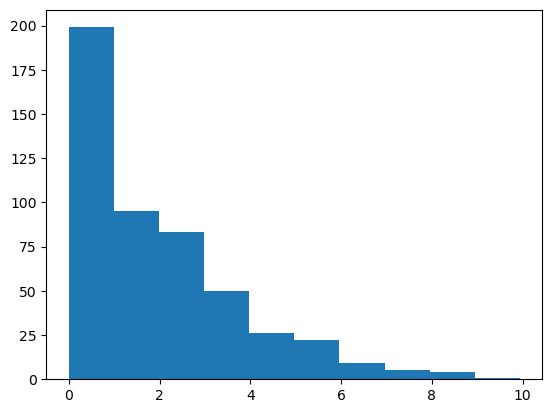

In [36]:
# delete the rows whose likelihood is less than -100
crash_data = crash_data[crash_data['crash_likelihood'] > -100]
# divide the likelihood by the maximum likelihood
crash_data['crash_likelihood'] = crash_data['crash_likelihood'] * 10 / (crash_data['crash_likelihood'].max() + 10)
plt.hist(crash_data['crash_likelihood'])

In [37]:
# add another column to sub_data to store the index
sub_data['index'] = sub_data.index + 1

In [38]:
# merge the two dataframes
final_data = pd.merge(sub_data, crash_data[['index', 'crash_likelihood']], on='index', how='inner')

In [39]:
del final_data['index']
final_data.to_csv('../../0_data/1_intermediate_ML/selected_features_one_hot_data_crash.csv', index=False)